<a href="https://colab.research.google.com/github/Manvi1718/FER_XAI/blob/main/GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision matplotlib opencv-python efficientnet_pytorch

import torch
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=f5c19831fee425cd5c6ddc25ca248a6960b35d0f06d6f21571fc99a1e0150475
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
import torch
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
import torch.nn as nn

# Load EfficientNet
efficientnet_model = EfficientNet.from_name('efficientnet-b0', num_classes=7)  # Specify the number of classes
efficientnet_model.load_state_dict(torch.load('/content/drive/MyDrive/efficientnet_model.pth', map_location=torch.device('cpu')))
efficientnet_model.eval()

# Load ResNet50
resnet50_model = models.resnet50()
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, 7)  # Change to match your number of classes
resnet50_model.load_state_dict(torch.load('/content/drive/MyDrive/ResNet50.pth', map_location=torch.device('cpu')))
resnet50_model.eval()


<ipython-input-7-d74a5ef78e80>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientnet_model.load_state_dict(torch.load('/content/drive/MyDrive/efficientnet_model.pth

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision.models import resnet50, efficientnet_b0, EfficientNet_B0_Weights

# Set the models to evaluation mode
efficientnet_model.eval()
resnet50_model.eval()

# Define the transformation for the input image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_gradcam(model, target_layer, img_path, target_category):
    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.convert('RGB')  # Ensure image is in RGB format
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch

    # Hook the layers to capture the gradients and activations
    gradients = []
    activations = []

    def save_gradient(module, grad_input, grad_output):
        gradients.append(grad_output[0])  # Save the gradient output

    def save_activation(module, input, output):
        activations.append(output)

    # Register hooks to the target layer
    target_layer.register_forward_hook(save_activation)
    target_layer.register_backward_hook(save_gradient)

    # Forward pass to get the outputs
    output = model(input_batch)

    # Get the target category if not provided
    if target_category is None:
        target_category = torch.argmax(output[0]).item()  # Get the index of the class with the highest score

    # Zero gradients and perform backpropagation
    model.zero_grad()
    loss = output[0][target_category]
    loss.backward()

    # Get the gradients and activations
    gradient = gradients[0].cpu().data.numpy()[0]
    activation = activations[0].cpu().data.numpy()[0]

    # Generate the Grad-CAM heatmap
    weights = np.mean(gradient, axis=(1, 2))  # Global Average Pooling
    cam = np.zeros(activation.shape[1:], dtype=np.float32)

    for i in range(len(weights)):
        cam += weights[i] * activation[i]

    cam = np.maximum(cam, 0)  # ReLU
    cam /= np.max(cam)  # Normalize

    return img, cam

def display_cam(original_img, heatmap):
    # Resize the heatmap to the size of the input image
    heatmap = cv2.resize(heatmap, (original_img.size[0], original_img.size[1]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(np.array(original_img), 0.5, heatmap_color, 0.5, 0)

    # Display the result
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()


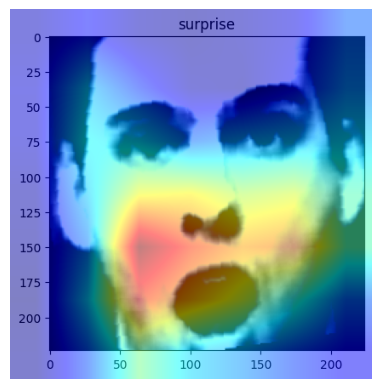

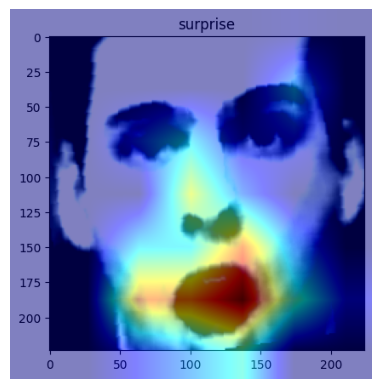

In [ ]:
# Example usage
img_path = '/content/drive/MyDrive/testimage2.png'
target_category = None  # Can specify a class index if needed

# For EfficientNet, access the last convolutional layer
efficientnet_layer = efficientnet_model.features[-1]

# Apply Grad-CAM for EfficientNet
original_img, heatmap = get_gradcam(efficientnet_model, efficientnet_layer, img_path, target_category)
display_cam(original_img, heatmap)

# For ResNet50, access the last convolutional layer
resnet50_layer = resnet50_model.layer4[-1].conv3

# Apply Grad-CAM for ResNet50
original_img, heatmap = get_gradcam(resnet50_model, resnet50_layer, img_path, target_category)
display_cam(original_img, heatmap)